用不同长度的轨迹训练自编码器

长度：3s

方法：双向重构

---




In [1]:
# 直接训练
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pickle
import os

from torch.utils.tensorboard import SummaryWriter

from model.PIAE_models import T8PIAE2, Vehicle_Model_Methods
import numpy as np

# 检查是否有可用的GPU
if torch.cuda.is_available():
    print('显卡参与训练')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 训练开始前启用 PyTorch 的异常检测
torch.autograd.set_detect_anomaly(True)

显卡参与训练


In [2]:
# 加载数据
# 1. 加载预处理后的数据
##

def load_preprocessed_data(input_file):
    with open(input_file, 'rb') as f:
        data = pickle.load(f)
    return data


input_file = '/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test8_add_different_time/data/data3s'  # 替换为你保存的.pkl文件路径

tarin_data = load_preprocessed_data(os.path.join(input_file,'train_data.kpl'))
val_data = load_preprocessed_data(os.path.join(input_file,'val_data.kpl'))
dataset = TensorDataset(tarin_data[0],tarin_data[1],tarin_data[2],tarin_data[3])

dataloader = DataLoader(dataset, batch_size=600, shuffle=True)

val_feat = val_data[0].to(device)
val_edagepoint = val_data[1].to(device)
val_endstate = val_data[2].to(device)
val_label = val_data[3].to(device)

In [3]:

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self,outputs, targets, actions):

        mse_loss = nn.MSELoss()(outputs, targets)

        # 平滑loss
        ax = actions[:, :, 0]
        delta = actions[:, :, 1]

        loss_ax = torch.mean(torch.abs(torch.diff(ax,dim=1)))
        loss_delta = torch.mean(torch.abs(torch.diff(delta,dim=1)))*10
    
        return mse_loss + 1e-3*(loss_ax+loss_delta)

In [4]:

# 3. 定义模型、损失函数和优化器
#模型
model = T8PIAE2(torch.tensor(10),torch.tensor(0.25),t_len=30)

# 损失函数
criterion = nn.MSELoss()
criterion_train = CustomLoss()

# 优化器
optimizer = optim.Adam(model.parameters(), lr=1e-3) 

model.to(device)


T8PIAE2(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=58, out_features=1200, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1200, out_features=600, bias=True)
    (4): ReLU()
  )
  (encoder_ax): Sequential(
    (0): Linear(in_features=300, out_features=600, bias=True)
    (1): ReLU()
    (2): Linear(in_features=600, out_features=28, bias=True)
    (3): Tanh()
  )
  (encoder_delta): Sequential(
    (0): Linear(in_features=300, out_features=600, bias=True)
    (1): ReLU()
    (2): Linear(in_features=600, out_features=28, bias=True)
    (3): Tanh()
  )
)

In [5]:
%clear

# 创建一个SummaryWriter对象，指定日志保存的路径
writer = SummaryWriter('/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test8_add_different_time/logs/log6')


# 4. 训练模型Autoencoder
epochs = 900

best_loss = float('inf')

for epoch in range(epochs):
    
    model.train()  # 确保模型处于训练模式
    for batch_idx, (feat,edagepoint,endstate,label) in enumerate(dataloader):  
        
        label = label.to(device)  # 将输入数据移动到同一设备
        feat = feat.to(device)
        edagepoint = edagepoint.to(device)
        endstate = endstate.to(device)

        optimizer.zero_grad()
        outputs,actions = model(feat,edagepoint,endstate)

        loss = criterion_train(outputs, label,actions)
        loss.backward()
        optimizer.step()


    model.eval()
    with torch.no_grad():
        val_output,val_action = model(val_feat,val_edagepoint,val_endstate)
        val_loss = criterion(val_output,val_label)
    
    # torch.save(model.state_dict(), f'/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test6_piae_good/model/Task4_trained_model/model_{epoch:03}.pth')
    if val_loss.item() < best_loss :
        # 保存模型
        torch.save(model.state_dict(), '/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test8_add_different_time/model/trained_models/Task6_model_best.pth')
        best_loss = val_loss.item()


    print(f'\rEpoch {epoch+1}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()} ')
    # print()
    # 使用SummaryWriter记录数据
    writer.add_scalar('Loss/train', loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)


# 关闭SummaryWriter
writer.close()
   


Epoch 1, Train Loss: 0.1762336641550064, Val Loss: 0.19310449063777924 


Epoch 2, Train Loss: 0.02032691054046154, Val Loss: 0.017565473914146423 


Epoch 3, Train Loss: 0.017583517357707024, Val Loss: 0.020326975733041763 


Epoch 4, Train Loss: 0.009743415750563145, Val Loss: 0.009721532464027405 


Epoch 5, Train Loss: 0.007948368787765503, Val Loss: 0.007659615483134985 


Epoch 6, Train Loss: 0.010345657356083393, Val Loss: 0.010846389457583427 


Epoch 7, Train Loss: 0.01083492860198021, Val Loss: 0.008439803496003151 


Epoch 8, Train Loss: 0.006382031831890345, Val Loss: 0.008254538290202618 


Epoch 9, Train Loss: 0.0075624859891831875, Val Loss: 0.01205467525869608 


Epoch 10, Train Loss: 0.0028470735996961594, Val Loss: 0.006138705648481846 


Epoch 11, Train Loss: 0.002880931831896305, Val Loss: 0.004571742378175259 


Epoch 12, Train Loss: 0.005777271464467049, Val Loss: 0.004753601737320423 


Epoch 13, Train Loss: 0.007808228489011526, Val Loss: 0.008289782330393791 


Epoch 14, Train Loss: 0.011011827737092972, Val Loss: 0.004348970949649811 


Epoch 15, Train Loss: 0.005053899250924587, Val Loss: 0.0069832950830459595 


Epoch 16, Train Loss: 0.003516305238008499, Val Loss: 0.004958196077495813 


Epoch 17, Train Loss: 0.0034116662573069334, Val Loss: 0.004857974126935005 


Epoch 18, Train Loss: 0.006974233780056238, Val Loss: 0.007414207793772221 


Epoch 19, Train Loss: 0.0030548034701496363, Val Loss: 0.005670163780450821 


Epoch 20, Train Loss: 0.0040162126533687115, Val Loss: 0.005419980268925428 


Epoch 21, Train Loss: 0.0051141297444701195, Val Loss: 0.00631821621209383 


Epoch 22, Train Loss: 0.004847953096032143, Val Loss: 0.006320135667920113 


Epoch 23, Train Loss: 0.00437738373875618, Val Loss: 0.005850406363606453 


Epoch 24, Train Loss: 0.008858058601617813, Val Loss: 0.005553651135414839 


Epoch 25, Train Loss: 0.002404147293418646, Val Loss: 0.003585572587326169 


Epoch 26, Train Loss: 0.0030839797109365463, Val Loss: 0.005807644221931696 


Epoch 27, Train Loss: 0.003986656200140715, Val Loss: 0.0074159493669867516 


Epoch 28, Train Loss: 0.004346679896116257, Val Loss: 0.005218836013227701 


Epoch 29, Train Loss: 0.0073144324123859406, Val Loss: 0.004552256781607866 


Epoch 30, Train Loss: 0.002807667711749673, Val Loss: 0.005477424710988998 


Epoch 31, Train Loss: 0.003001582808792591, Val Loss: 0.004580365028232336 


Epoch 32, Train Loss: 0.002752907108515501, Val Loss: 0.0037589867133647203 


Epoch 33, Train Loss: 0.007862195372581482, Val Loss: 0.006537758745253086 


Epoch 34, Train Loss: 0.003005371429026127, Val Loss: 0.00453614816069603 


Epoch 35, Train Loss: 0.0038714888505637646, Val Loss: 0.004676437471061945 


Epoch 36, Train Loss: 0.003117581829428673, Val Loss: 0.004278797190636396 


Epoch 37, Train Loss: 0.004371776711195707, Val Loss: 0.006034597288817167 


Epoch 38, Train Loss: 0.0042482102289795876, Val Loss: 0.004809602629393339 


Epoch 39, Train Loss: 0.005078640300780535, Val Loss: 0.005131267476826906 


Epoch 40, Train Loss: 0.004849552642554045, Val Loss: 0.0059983995743095875 


Epoch 41, Train Loss: 0.0025359292048960924, Val Loss: 0.003896661102771759 


Epoch 42, Train Loss: 0.005552500486373901, Val Loss: 0.006091987248510122 


Epoch 43, Train Loss: 0.004998333752155304, Val Loss: 0.007746677380055189 


Epoch 44, Train Loss: 0.002213492291048169, Val Loss: 0.004086918663233519 


Epoch 45, Train Loss: 0.003192173782736063, Val Loss: 0.0037609876599162817 


Epoch 46, Train Loss: 0.004823195282369852, Val Loss: 0.004134034272283316 


Epoch 47, Train Loss: 0.004378202836960554, Val Loss: 0.005263525526970625 


Epoch 48, Train Loss: 0.004693127702921629, Val Loss: 0.005372550338506699 


Epoch 49, Train Loss: 0.0025576860643923283, Val Loss: 0.0035180782433599234 


Epoch 50, Train Loss: 0.00893055647611618, Val Loss: 0.005173691548407078 


Epoch 51, Train Loss: 0.00563795818015933, Val Loss: 0.003926553763449192 


Epoch 52, Train Loss: 0.0021930367220193148, Val Loss: 0.003312736051157117 


Epoch 53, Train Loss: 0.0023184872698038816, Val Loss: 0.004395125899463892 


Epoch 54, Train Loss: 0.003233069321140647, Val Loss: 0.003476441139355302 


Epoch 55, Train Loss: 0.005259298719465733, Val Loss: 0.003359190421178937 


Epoch 56, Train Loss: 0.00256460253149271, Val Loss: 0.0038150891195982695 


Epoch 57, Train Loss: 0.0024886149913072586, Val Loss: 0.002897726371884346 


Epoch 58, Train Loss: 0.0030251566786319017, Val Loss: 0.005221494473516941 


Epoch 59, Train Loss: 0.003647653153166175, Val Loss: 0.0036077159456908703 


Epoch 60, Train Loss: 0.0022130263969302177, Val Loss: 0.003584012622013688 


Epoch 61, Train Loss: 0.001772546675056219, Val Loss: 0.0028376360423862934 


Epoch 62, Train Loss: 0.002451190259307623, Val Loss: 0.005447833798825741 


Epoch 63, Train Loss: 0.014320546761155128, Val Loss: 0.006675053853541613 


Epoch 64, Train Loss: 0.0028034669812768698, Val Loss: 0.005170322023332119 


Epoch 65, Train Loss: 0.004456530790776014, Val Loss: 0.003454008838161826 


Epoch 66, Train Loss: 0.0030638582538813353, Val Loss: 0.0029689494986087084 


Epoch 67, Train Loss: 0.005845905747264624, Val Loss: 0.0034023013431578875 


Epoch 68, Train Loss: 0.0071075488813221455, Val Loss: 0.004662782419472933 


Epoch 69, Train Loss: 0.004477133508771658, Val Loss: 0.0037151798605918884 


Epoch 70, Train Loss: 0.002830457640811801, Val Loss: 0.0031837024725973606 


Epoch 71, Train Loss: 0.0025258504319936037, Val Loss: 0.0032203064765781164 


Epoch 72, Train Loss: 0.002391131827607751, Val Loss: 0.003664380172267556 


Epoch 73, Train Loss: 0.0016156492056325078, Val Loss: 0.002741621108725667 


Epoch 74, Train Loss: 0.0023991363123059273, Val Loss: 0.003187947440892458 


Epoch 75, Train Loss: 0.0024310534354299307, Val Loss: 0.0032802007626742125 


Epoch 76, Train Loss: 0.004293510224670172, Val Loss: 0.0032421480864286423 


Epoch 77, Train Loss: 0.0022826530039310455, Val Loss: 0.004536558408290148 


Epoch 78, Train Loss: 0.0021500769071280956, Val Loss: 0.0035012729931622744 


Epoch 79, Train Loss: 0.0026945704594254494, Val Loss: 0.0030528029892593622 


Epoch 80, Train Loss: 0.002042247913777828, Val Loss: 0.002939250785857439 


Epoch 81, Train Loss: 0.002144517609849572, Val Loss: 0.003431380959227681 


Epoch 82, Train Loss: 0.001951741985976696, Val Loss: 0.0036998724099248648 


Epoch 83, Train Loss: 0.0023306752555072308, Val Loss: 0.0025165986735373735 


Epoch 84, Train Loss: 0.0018756384961307049, Val Loss: 0.003065402153879404 


Epoch 85, Train Loss: 0.0035423412919044495, Val Loss: 0.0034348953049629927 


Epoch 86, Train Loss: 0.0041131312027573586, Val Loss: 0.00463867885991931 


Epoch 87, Train Loss: 0.0016858859453350306, Val Loss: 0.0034139049239456654 


Epoch 88, Train Loss: 0.0022251915652304888, Val Loss: 0.0034847017377614975 


Epoch 89, Train Loss: 0.0025788419879972935, Val Loss: 0.0031229848973453045 


Epoch 90, Train Loss: 0.003658020868897438, Val Loss: 0.0036466738674789667 


Epoch 91, Train Loss: 0.002285144291818142, Val Loss: 0.0028575300239026546 


Epoch 92, Train Loss: 0.005129359662532806, Val Loss: 0.0033309482969343662 


Epoch 93, Train Loss: 0.001935643027536571, Val Loss: 0.002982387552037835 


Epoch 94, Train Loss: 0.002052882220596075, Val Loss: 0.003018188988789916 


Epoch 95, Train Loss: 0.0023157994728535414, Val Loss: 0.0031445117201656103 


Epoch 96, Train Loss: 0.005435354076325893, Val Loss: 0.00302499788813293 


Epoch 97, Train Loss: 0.001510581118054688, Val Loss: 0.002841876121237874 


Epoch 98, Train Loss: 0.0054788244888186455, Val Loss: 0.0054756817407906055 


Epoch 99, Train Loss: 0.0014776221942156553, Val Loss: 0.002881981199607253 


Epoch 100, Train Loss: 0.00229847664013505, Val Loss: 0.002780100330710411 


Epoch 101, Train Loss: 0.0022317245602607727, Val Loss: 0.0027886792086064816 


Epoch 102, Train Loss: 0.0014876141212880611, Val Loss: 0.00258623412810266 


Epoch 103, Train Loss: 0.0027029288467019796, Val Loss: 0.002608507638797164 


Epoch 104, Train Loss: 0.006949790753424168, Val Loss: 0.002483663847669959 


Epoch 105, Train Loss: 0.0034808386117219925, Val Loss: 0.005459391511976719 


Epoch 106, Train Loss: 0.0018492038361728191, Val Loss: 0.00527714379131794 


Epoch 107, Train Loss: 0.001786569831892848, Val Loss: 0.0025613040197640657 


Epoch 108, Train Loss: 0.003325676778331399, Val Loss: 0.0029889820143580437 


Epoch 109, Train Loss: 0.0018037885893136263, Val Loss: 0.002957436488941312 


Epoch 110, Train Loss: 0.002513541840016842, Val Loss: 0.0036601582542061806 


Epoch 111, Train Loss: 0.0033011166378855705, Val Loss: 0.005466314032673836 


Epoch 112, Train Loss: 0.0024375703651458025, Val Loss: 0.0037182189989835024 


Epoch 113, Train Loss: 0.0023094580974429846, Val Loss: 0.0037258474621921778 


Epoch 114, Train Loss: 0.0017773988656699657, Val Loss: 0.0025937447790056467 


Epoch 115, Train Loss: 0.002077971352264285, Val Loss: 0.0027811673935502768 


Epoch 116, Train Loss: 0.0015375508228316903, Val Loss: 0.002512544160708785 


Epoch 117, Train Loss: 0.0018388730240985751, Val Loss: 0.0032512641046196222 


Epoch 118, Train Loss: 0.0017313807038590312, Val Loss: 0.003517237026244402 


Epoch 119, Train Loss: 0.0023367467802017927, Val Loss: 0.004240706097334623 


Epoch 120, Train Loss: 0.00580107606947422, Val Loss: 0.0025805679615586996 


Epoch 121, Train Loss: 0.0015882167499512434, Val Loss: 0.003340985393151641 


Epoch 122, Train Loss: 0.0019199952948838472, Val Loss: 0.0034126993268728256 


Epoch 123, Train Loss: 0.0012092390097677708, Val Loss: 0.002375391311943531 


Epoch 124, Train Loss: 0.002161552896723151, Val Loss: 0.0029089665040373802 


Epoch 125, Train Loss: 0.0015370742185041308, Val Loss: 0.002677713753655553 


Epoch 126, Train Loss: 0.0014555893139913678, Val Loss: 0.0025078137405216694 


Epoch 127, Train Loss: 0.001580757205374539, Val Loss: 0.002741162432357669 


Epoch 128, Train Loss: 0.006824870128184557, Val Loss: 0.0047903829254209995 


Epoch 129, Train Loss: 0.0014272350817918777, Val Loss: 0.0025714596267789602 


Epoch 130, Train Loss: 0.002326596062630415, Val Loss: 0.003568287007510662 


Epoch 131, Train Loss: 0.0022583736572414637, Val Loss: 0.003164049470797181 


Epoch 132, Train Loss: 0.002090833382681012, Val Loss: 0.002778835827484727 


Epoch 133, Train Loss: 0.0021733958274126053, Val Loss: 0.0027126730419695377 


Epoch 134, Train Loss: 0.0023520493414252996, Val Loss: 0.0031285835430026054 


Epoch 135, Train Loss: 0.0015882672742009163, Val Loss: 0.002598800230771303 


Epoch 136, Train Loss: 0.0015100481687113643, Val Loss: 0.0023080238606780767 


Epoch 137, Train Loss: 0.0020343968644738197, Val Loss: 0.0022361380979418755 


Epoch 138, Train Loss: 0.002088135341182351, Val Loss: 0.0029931224416941404 


Epoch 139, Train Loss: 0.0030661234632134438, Val Loss: 0.003305480582639575 


Epoch 140, Train Loss: 0.001487627625465393, Val Loss: 0.002504064003005624 


Epoch 141, Train Loss: 0.0017906192224472761, Val Loss: 0.0025703036226332188 


Epoch 142, Train Loss: 0.0016133838798850775, Val Loss: 0.002662254963070154 


Epoch 143, Train Loss: 0.0022838814184069633, Val Loss: 0.0031828831415623426 


Epoch 144, Train Loss: 0.001862999051809311, Val Loss: 0.003312269225716591 


Epoch 145, Train Loss: 0.0009023669408634305, Val Loss: 0.0025041948538273573 


Epoch 146, Train Loss: 0.00614688778296113, Val Loss: 0.002516255248337984 


Epoch 147, Train Loss: 0.0024952178355306387, Val Loss: 0.002425163285806775 


Epoch 148, Train Loss: 0.002567053074017167, Val Loss: 0.0022647662553936243 


Epoch 149, Train Loss: 0.004416408017277718, Val Loss: 0.002459967276081443 


Epoch 150, Train Loss: 0.003046604571864009, Val Loss: 0.0030905648600310087 


Epoch 151, Train Loss: 0.002136215567588806, Val Loss: 0.003114077728241682 


Epoch 152, Train Loss: 0.0012876885011792183, Val Loss: 0.0024365566205233335 


Epoch 153, Train Loss: 0.0021600709296762943, Val Loss: 0.0024109124206006527 


Epoch 154, Train Loss: 0.00207331869751215, Val Loss: 0.004133677110075951 


Epoch 155, Train Loss: 0.0014872747706249356, Val Loss: 0.0025464582722634077 


Epoch 156, Train Loss: 0.005041881930083036, Val Loss: 0.0032228538766503334 


Epoch 157, Train Loss: 0.0042770784348249435, Val Loss: 0.0030714424792677164 


Epoch 158, Train Loss: 0.007182507775723934, Val Loss: 0.003079403890296817 


Epoch 159, Train Loss: 0.002632922725751996, Val Loss: 0.0028003607876598835 


Epoch 160, Train Loss: 0.001077628810890019, Val Loss: 0.002635581186041236 


Epoch 161, Train Loss: 0.0026840739883482456, Val Loss: 0.0032410086132586002 


Epoch 162, Train Loss: 0.001599960494786501, Val Loss: 0.00246565998531878 


Epoch 163, Train Loss: 0.005635961424559355, Val Loss: 0.006607672665268183 


Epoch 164, Train Loss: 0.003618896007537842, Val Loss: 0.0024036290124058723 


Epoch 165, Train Loss: 0.0029548488091677427, Val Loss: 0.0035615761298686266 


Epoch 166, Train Loss: 0.0016399509040638804, Val Loss: 0.002680091420188546 


Epoch 167, Train Loss: 0.0015513357939198613, Val Loss: 0.0023610051721334457 


Epoch 168, Train Loss: 0.0021570539101958275, Val Loss: 0.0025188405998051167 


Epoch 169, Train Loss: 0.002106855157762766, Val Loss: 0.002486534183844924 


Epoch 170, Train Loss: 0.0024229639675468206, Val Loss: 0.002932504517957568 


Epoch 171, Train Loss: 0.0015966227510944009, Val Loss: 0.002621266758069396 


Epoch 172, Train Loss: 0.005743515677750111, Val Loss: 0.0036680116318166256 


Epoch 173, Train Loss: 0.0014527109451591969, Val Loss: 0.002490757964551449 


Epoch 174, Train Loss: 0.0028601507656276226, Val Loss: 0.0035447191912680864 


Epoch 175, Train Loss: 0.003665252821519971, Val Loss: 0.003268953412771225 


Epoch 176, Train Loss: 0.001878086943179369, Val Loss: 0.003515735035762191 


Epoch 177, Train Loss: 0.004328824579715729, Val Loss: 0.002772834850475192 


Epoch 178, Train Loss: 0.0011049911845475435, Val Loss: 0.0023836889304220676 


Epoch 179, Train Loss: 0.0023992732167243958, Val Loss: 0.0022407788783311844 


Epoch 180, Train Loss: 0.0016643130220472813, Val Loss: 0.0024770572781562805 


Epoch 181, Train Loss: 0.009400459006428719, Val Loss: 0.018341051414608955 


Epoch 182, Train Loss: 0.00112747005186975, Val Loss: 0.0022927140817046165 


Epoch 183, Train Loss: 0.0032848746050149202, Val Loss: 0.003074779873713851 


Epoch 184, Train Loss: 0.0019462481141090393, Val Loss: 0.0026862742379307747 


Epoch 185, Train Loss: 0.0021622255444526672, Val Loss: 0.002731842454522848 


Epoch 186, Train Loss: 0.0012363358400762081, Val Loss: 0.002894227160140872 


Epoch 187, Train Loss: 0.001070573227480054, Val Loss: 0.003047539619728923 


Epoch 188, Train Loss: 0.0021759236697107553, Val Loss: 0.0034144797828048468 


Epoch 189, Train Loss: 0.0017405622638761997, Val Loss: 0.0024707471020519733 


Epoch 190, Train Loss: 0.005104343872517347, Val Loss: 0.0032129036262631416 


Epoch 191, Train Loss: 0.002855024766176939, Val Loss: 0.0030907944310456514 


Epoch 192, Train Loss: 0.0012753268238157034, Val Loss: 0.0023152027279138565 


Epoch 193, Train Loss: 0.0012438201811164618, Val Loss: 0.0023847389966249466 


Epoch 194, Train Loss: 0.0020103557035326958, Val Loss: 0.002435416216030717 


Epoch 195, Train Loss: 0.0020081328693777323, Val Loss: 0.002727444050833583 


Epoch 196, Train Loss: 0.0020091901533305645, Val Loss: 0.0029612539801746607 


Epoch 197, Train Loss: 0.0014793408336117864, Val Loss: 0.0022861426696181297 


Epoch 198, Train Loss: 0.002071387367323041, Val Loss: 0.0025740652345120907 


Epoch 199, Train Loss: 0.0016567276325076818, Val Loss: 0.0028185660485178232 


Epoch 200, Train Loss: 0.0015027545159682631, Val Loss: 0.003128087380900979 


Epoch 201, Train Loss: 0.001996398903429508, Val Loss: 0.0027763412799686193 


Epoch 202, Train Loss: 0.0025986642576754093, Val Loss: 0.003074675565585494 


Epoch 203, Train Loss: 0.002336859004572034, Val Loss: 0.002444205107167363 


Epoch 204, Train Loss: 0.001495039090514183, Val Loss: 0.0026119137182831764 


Epoch 205, Train Loss: 0.0014136559329926968, Val Loss: 0.003230683272704482 


Epoch 206, Train Loss: 0.0013331356458365917, Val Loss: 0.002748391591012478 


Epoch 207, Train Loss: 0.001575089176185429, Val Loss: 0.002679228549823165 


Epoch 208, Train Loss: 0.0013739881105720997, Val Loss: 0.002650547306984663 


Epoch 209, Train Loss: 0.0011226311326026917, Val Loss: 0.002740956610068679 


Epoch 210, Train Loss: 0.001541163306683302, Val Loss: 0.0025283677969127893 


Epoch 211, Train Loss: 0.002319159684702754, Val Loss: 0.0035252568777650595 


Epoch 212, Train Loss: 0.00435968954116106, Val Loss: 0.004017708357423544 


Epoch 213, Train Loss: 0.0018901547882705927, Val Loss: 0.004521679598838091 


Epoch 214, Train Loss: 0.0017497566295787692, Val Loss: 0.002444544341415167 


Epoch 215, Train Loss: 0.0014932033373042941, Val Loss: 0.003643349977210164 


Epoch 216, Train Loss: 0.0028141469229012728, Val Loss: 0.003692514030262828 


Epoch 217, Train Loss: 0.0016560349613428116, Val Loss: 0.0024896543473005295 


Epoch 218, Train Loss: 0.0013290101196616888, Val Loss: 0.002867689123377204 


Epoch 219, Train Loss: 0.0056851706467568874, Val Loss: 0.0047791991382837296 


Epoch 220, Train Loss: 0.004791154060512781, Val Loss: 0.0026999509427696466 


Epoch 221, Train Loss: 0.0024606729857623577, Val Loss: 0.0028387445490807295 


Epoch 222, Train Loss: 0.0012210013810545206, Val Loss: 0.0029922095127403736 


Epoch 223, Train Loss: 0.0025193181354552507, Val Loss: 0.003699556225910783 


Epoch 224, Train Loss: 0.0016269998159259558, Val Loss: 0.0025902786292135715 


Epoch 225, Train Loss: 0.0034726536832749844, Val Loss: 0.002445851219817996 


Epoch 226, Train Loss: 0.0011037788353860378, Val Loss: 0.002551877638325095 


Epoch 227, Train Loss: 0.0019922356586903334, Val Loss: 0.0028114833403378725 


Epoch 228, Train Loss: 0.0014304876094684005, Val Loss: 0.002325642155483365 


Epoch 229, Train Loss: 0.0018247195985168219, Val Loss: 0.0024125140625983477 


Epoch 230, Train Loss: 0.0041748592630028725, Val Loss: 0.00269185658544302 


Epoch 231, Train Loss: 0.0016117211198434234, Val Loss: 0.0029510159511119127 


Epoch 232, Train Loss: 0.0031887171790003777, Val Loss: 0.0027615411672741175 


Epoch 233, Train Loss: 0.003349198028445244, Val Loss: 0.004035919904708862 


Epoch 234, Train Loss: 0.0026766115333884954, Val Loss: 0.003942673560231924 


Epoch 235, Train Loss: 0.003019684227183461, Val Loss: 0.0022295238450169563 


Epoch 236, Train Loss: 0.001447881804779172, Val Loss: 0.002573723904788494 


Epoch 237, Train Loss: 0.02477041631937027, Val Loss: 0.0024040008429437876 


Epoch 238, Train Loss: 0.0017689097439870238, Val Loss: 0.0028353866655379534 


Epoch 239, Train Loss: 0.001695143524557352, Val Loss: 0.0026955557987093925 


Epoch 240, Train Loss: 0.0016051089623942971, Val Loss: 0.002735672052949667 


Epoch 241, Train Loss: 0.002043619053438306, Val Loss: 0.002611474134027958 


Epoch 242, Train Loss: 0.004750712774693966, Val Loss: 0.0025562611408531666 


Epoch 243, Train Loss: 0.0014304714277386665, Val Loss: 0.0032307205256074667 


Epoch 244, Train Loss: 0.004286730661988258, Val Loss: 0.0036645610816776752 


Epoch 245, Train Loss: 0.0016585676930844784, Val Loss: 0.002496053697541356 


Epoch 246, Train Loss: 0.0016730045899748802, Val Loss: 0.0026370917912572622 


Epoch 247, Train Loss: 0.002222406677901745, Val Loss: 0.002931984607130289 


Epoch 248, Train Loss: 0.0011292118579149246, Val Loss: 0.002293520839884877 


Epoch 249, Train Loss: 0.0022856860887259245, Val Loss: 0.003058461006730795 


Epoch 250, Train Loss: 0.0015668137930333614, Val Loss: 0.0025171474553644657 


Epoch 251, Train Loss: 0.0013493052683770657, Val Loss: 0.0024186931550502777 


Epoch 252, Train Loss: 0.0012187110260128975, Val Loss: 0.0024145450443029404 


Epoch 253, Train Loss: 0.001275299466215074, Val Loss: 0.0025508429389446974 


Epoch 254, Train Loss: 0.0009554160060361028, Val Loss: 0.002503892406821251 


Epoch 255, Train Loss: 0.0009568836539983749, Val Loss: 0.0022923266515135765 


Epoch 256, Train Loss: 0.00454255286604166, Val Loss: 0.0022789626382291317 


Epoch 257, Train Loss: 0.0018243041122332215, Val Loss: 0.002605689689517021 


Epoch 258, Train Loss: 0.0029890171717852354, Val Loss: 0.002385740401223302 


Epoch 259, Train Loss: 0.002254013903439045, Val Loss: 0.0030129102524369955 


Epoch 260, Train Loss: 0.001378726097755134, Val Loss: 0.0023713624104857445 


Epoch 261, Train Loss: 0.003591518849134445, Val Loss: 0.0045804656110703945 


Epoch 262, Train Loss: 0.003255154937505722, Val Loss: 0.0024534298572689295 


Epoch 263, Train Loss: 0.002528162905946374, Val Loss: 0.004999622702598572 


Epoch 264, Train Loss: 0.003595759393647313, Val Loss: 0.003456671256572008 


Epoch 265, Train Loss: 0.00301356241106987, Val Loss: 0.003772930707782507 


Epoch 266, Train Loss: 0.0018438578117638826, Val Loss: 0.002537650056183338 


Epoch 267, Train Loss: 0.0014721003826707602, Val Loss: 0.0025236112996935844 


Epoch 268, Train Loss: 0.0013196530053392053, Val Loss: 0.0022486811503767967 


Epoch 269, Train Loss: 0.0015818923711776733, Val Loss: 0.0024562699254602194 


Epoch 270, Train Loss: 0.0015736714703962207, Val Loss: 0.0024329330772161484 


Epoch 271, Train Loss: 0.002127300249412656, Val Loss: 0.0025260308757424355 


Epoch 272, Train Loss: 0.0016752984374761581, Val Loss: 0.00238635390996933 


Epoch 273, Train Loss: 0.002600638195872307, Val Loss: 0.004440939053893089 


Epoch 274, Train Loss: 0.0017176303081214428, Val Loss: 0.0024734127800911665 


Epoch 275, Train Loss: 0.0014029606245458126, Val Loss: 0.0026253992691636086 


Epoch 276, Train Loss: 0.0025564467068761587, Val Loss: 0.0024244559463113546 


Epoch 277, Train Loss: 0.004714487120509148, Val Loss: 0.005360394716262817 


Epoch 278, Train Loss: 0.0022358561400324106, Val Loss: 0.0023333460558205843 


Epoch 279, Train Loss: 0.0009912536479532719, Val Loss: 0.0027403514832258224 


Epoch 280, Train Loss: 0.0029481579549610615, Val Loss: 0.002707014326006174 


Epoch 281, Train Loss: 0.0026072405744343996, Val Loss: 0.0035143999848514795 


Epoch 282, Train Loss: 0.0023865040857344866, Val Loss: 0.0028726113960146904 


Epoch 283, Train Loss: 0.0019653779454529285, Val Loss: 0.0030862544663250446 


Epoch 284, Train Loss: 0.0023413437884300947, Val Loss: 0.003581601195037365 


Epoch 285, Train Loss: 0.003249872475862503, Val Loss: 0.0036544918548315763 


Epoch 286, Train Loss: 0.0022134012542665005, Val Loss: 0.0023793401196599007 


Epoch 287, Train Loss: 0.002162132877856493, Val Loss: 0.0025537998881191015 


Epoch 288, Train Loss: 0.0012923339381814003, Val Loss: 0.002644025254994631 


Epoch 289, Train Loss: 0.0028096078895032406, Val Loss: 0.003399925772100687 


Epoch 290, Train Loss: 0.0029349117539823055, Val Loss: 0.0024763476103544235 


Epoch 291, Train Loss: 0.002082078019157052, Val Loss: 0.0021573351696133614 


Epoch 292, Train Loss: 0.02447321079671383, Val Loss: 0.002856888808310032 


Epoch 293, Train Loss: 0.00581863708794117, Val Loss: 0.002760892268270254 


Epoch 294, Train Loss: 0.0027154735289514065, Val Loss: 0.0034656599164009094 


Epoch 295, Train Loss: 0.0024153473787009716, Val Loss: 0.003835393348708749 


Epoch 296, Train Loss: 0.004820589907467365, Val Loss: 0.002636220073327422 


Epoch 297, Train Loss: 0.00454720901325345, Val Loss: 0.0024238296318799257 


Epoch 298, Train Loss: 0.0012030559591948986, Val Loss: 0.002344236709177494 


Epoch 299, Train Loss: 0.004944762215018272, Val Loss: 0.002591499127447605 


Epoch 300, Train Loss: 0.0015121584292501211, Val Loss: 0.0025205921847373247 


Epoch 301, Train Loss: 0.002113687340170145, Val Loss: 0.0025538054760545492 


Epoch 302, Train Loss: 0.002601217944175005, Val Loss: 0.0027459338307380676 


Epoch 303, Train Loss: 0.0014781923964619637, Val Loss: 0.0028030790854245424 


Epoch 304, Train Loss: 0.0021372856572270393, Val Loss: 0.0026447921991348267 


Epoch 305, Train Loss: 0.0021781083196401596, Val Loss: 0.002351367613300681 


Epoch 306, Train Loss: 0.0013348432257771492, Val Loss: 0.00261578056961298 


Epoch 307, Train Loss: 0.0016254247166216373, Val Loss: 0.0024295870680361986 


Epoch 308, Train Loss: 0.00233829440549016, Val Loss: 0.0031973652075976133 


Epoch 309, Train Loss: 0.0011908368906006217, Val Loss: 0.002514718798920512 


Epoch 310, Train Loss: 0.001462685177102685, Val Loss: 0.002485420322045684 


Epoch 311, Train Loss: 0.002657464938238263, Val Loss: 0.002417259616777301 


Epoch 312, Train Loss: 0.0018139611929655075, Val Loss: 0.0028985042590647936 


Epoch 313, Train Loss: 0.0011573192896321416, Val Loss: 0.0027204789221286774 


Epoch 314, Train Loss: 0.0012750462628901005, Val Loss: 0.0023658827412873507 


Epoch 315, Train Loss: 0.0022981539368629456, Val Loss: 0.0029873184394091368 


Epoch 316, Train Loss: 0.0017870947485789657, Val Loss: 0.00261599849909544 


Epoch 317, Train Loss: 0.0011431168531998992, Val Loss: 0.0024459809064865112 


Epoch 318, Train Loss: 0.0020901181269437075, Val Loss: 0.003125528572127223 


Epoch 319, Train Loss: 0.002719780895859003, Val Loss: 0.002300708321854472 


Epoch 320, Train Loss: 0.0009362492710351944, Val Loss: 0.0023778174072504044 


Epoch 321, Train Loss: 0.0010988240828737617, Val Loss: 0.0024209304247051477 


Epoch 322, Train Loss: 0.0016772374510765076, Val Loss: 0.002773161744698882 


Epoch 323, Train Loss: 0.0017089764587581158, Val Loss: 0.0027960757724940777 


Epoch 324, Train Loss: 0.002852796111255884, Val Loss: 0.0025952421128749847 


Epoch 325, Train Loss: 0.0024687028490006924, Val Loss: 0.0024811378680169582 


Epoch 326, Train Loss: 0.005116698797792196, Val Loss: 0.0025603268295526505 


Epoch 327, Train Loss: 0.0019208762096241117, Val Loss: 0.003014511661604047 


Epoch 328, Train Loss: 0.00242966553196311, Val Loss: 0.002336883218958974 


Epoch 329, Train Loss: 0.004408836364746094, Val Loss: 0.0023452257737517357 


Epoch 330, Train Loss: 0.0026038195937871933, Val Loss: 0.0024487029295414686 


Epoch 331, Train Loss: 0.001035867491737008, Val Loss: 0.002313012722879648 


Epoch 332, Train Loss: 0.0020948564633727074, Val Loss: 0.0024608492385596037 


Epoch 333, Train Loss: 0.001343732699751854, Val Loss: 0.0025707075837999582 


Epoch 334, Train Loss: 0.002081112237647176, Val Loss: 0.0037490364629775286 


Epoch 335, Train Loss: 0.0018380559049546719, Val Loss: 0.0030268030241131783 


Epoch 336, Train Loss: 0.004317202605307102, Val Loss: 0.0025185260456055403 


Epoch 337, Train Loss: 0.0011345873354002833, Val Loss: 0.0022795372642576694 


Epoch 338, Train Loss: 0.0020063649863004684, Val Loss: 0.0028805916663259268 


Epoch 339, Train Loss: 0.003619284136220813, Val Loss: 0.0023075733333826065 


Epoch 340, Train Loss: 0.0010179493110626936, Val Loss: 0.0022824734915047884 


Epoch 341, Train Loss: 0.0019379935692995787, Val Loss: 0.0024719994980841875 


Epoch 342, Train Loss: 0.0010658876271918416, Val Loss: 0.002242102986201644 


Epoch 343, Train Loss: 0.0015973406843841076, Val Loss: 0.002426561200991273 


Epoch 344, Train Loss: 0.0009510860545560718, Val Loss: 0.002246344927698374 


Epoch 345, Train Loss: 0.0015284002292901278, Val Loss: 0.0026553242933005095 


Epoch 346, Train Loss: 0.0022279161494225264, Val Loss: 0.0028310250490903854 


Epoch 347, Train Loss: 0.0018115590792149305, Val Loss: 0.002681231591850519 


Epoch 348, Train Loss: 0.0020516766235232353, Val Loss: 0.0023737684823572636 


Epoch 349, Train Loss: 0.0024443580769002438, Val Loss: 0.002490726765245199 


Epoch 350, Train Loss: 0.00216888845898211, Val Loss: 0.003043173346668482 


Epoch 351, Train Loss: 0.0016120625659823418, Val Loss: 0.0024507734924554825 


Epoch 352, Train Loss: 0.001060212031006813, Val Loss: 0.0023777633905410767 


Epoch 353, Train Loss: 0.001693427562713623, Val Loss: 0.0024937093257904053 


Epoch 354, Train Loss: 0.0012831173371523619, Val Loss: 0.0028550690039992332 


Epoch 355, Train Loss: 0.002176779555156827, Val Loss: 0.0026472348254173994 


Epoch 356, Train Loss: 0.0016188709996640682, Val Loss: 0.002319399965927005 


Epoch 357, Train Loss: 0.0012219954514876008, Val Loss: 0.002416097093373537 


Epoch 358, Train Loss: 0.0012571463594213128, Val Loss: 0.0025514326989650726 


Epoch 359, Train Loss: 0.0012676226906478405, Val Loss: 0.002544622402638197 


Epoch 360, Train Loss: 0.002932306146249175, Val Loss: 0.0031128055416047573 


Epoch 361, Train Loss: 0.0017662302125245333, Val Loss: 0.0026987872552126646 


Epoch 362, Train Loss: 0.0014305537333711982, Val Loss: 0.00233053439296782 


Epoch 363, Train Loss: 0.0014771230053156614, Val Loss: 0.0023815196473151445 


Epoch 364, Train Loss: 0.0009647683473303914, Val Loss: 0.0024174123536795378 


Epoch 365, Train Loss: 0.0013922421494498849, Val Loss: 0.0023870854638516903 


Epoch 366, Train Loss: 0.00148646195884794, Val Loss: 0.002353656804189086 


Epoch 367, Train Loss: 0.0014049987075850368, Val Loss: 0.0023509229067713022 


Epoch 368, Train Loss: 0.002535259583964944, Val Loss: 0.003004092024639249 


Epoch 369, Train Loss: 0.005127502605319023, Val Loss: 0.0023815534077584743 


Epoch 370, Train Loss: 0.0017367302207276225, Val Loss: 0.00232898211106658 


Epoch 371, Train Loss: 0.0018474357202649117, Val Loss: 0.0034502772614359856 


Epoch 372, Train Loss: 0.0011540972627699375, Val Loss: 0.0022804774343967438 


Epoch 373, Train Loss: 0.0014088242314755917, Val Loss: 0.0028327377513051033 


Epoch 374, Train Loss: 0.0026362782809883356, Val Loss: 0.0021932979580014944 


Epoch 375, Train Loss: 0.0016014897264540195, Val Loss: 0.002410683548077941 


Epoch 376, Train Loss: 0.001038513146340847, Val Loss: 0.0023338785395026207 


Epoch 377, Train Loss: 0.0026546523440629244, Val Loss: 0.003603325691074133 


Epoch 378, Train Loss: 0.0015734925400465727, Val Loss: 0.002389378845691681 


Epoch 379, Train Loss: 0.005578544922173023, Val Loss: 0.0026707148645073175 


Epoch 380, Train Loss: 0.0014769042609259486, Val Loss: 0.0024143485352396965 


Epoch 381, Train Loss: 0.002378309378400445, Val Loss: 0.004952291026711464 


Epoch 382, Train Loss: 0.024667896330356598, Val Loss: 0.0025107553228735924 


Epoch 383, Train Loss: 0.0014220947632566094, Val Loss: 0.002698458731174469 


Epoch 384, Train Loss: 0.0036464680451899767, Val Loss: 0.0025007985532283783 


Epoch 385, Train Loss: 0.0024943496100604534, Val Loss: 0.0023012959863990545 


Epoch 386, Train Loss: 0.001268772641196847, Val Loss: 0.002945059910416603 


Epoch 387, Train Loss: 0.002135790651664138, Val Loss: 0.0022501314524561167 


Epoch 388, Train Loss: 0.001636816537939012, Val Loss: 0.0024048974737524986 


Epoch 389, Train Loss: 0.002252634149044752, Val Loss: 0.0027636727318167686 


Epoch 390, Train Loss: 0.002573074772953987, Val Loss: 0.002262479392811656 


Epoch 391, Train Loss: 0.0013625537976622581, Val Loss: 0.0024720449000597 


Epoch 392, Train Loss: 0.0035937149077653885, Val Loss: 0.002225326607003808 


Epoch 393, Train Loss: 0.0028629221487790346, Val Loss: 0.002209536964073777 


Epoch 394, Train Loss: 0.001508530811406672, Val Loss: 0.0028562441002577543 


Epoch 395, Train Loss: 0.0016515052411705256, Val Loss: 0.003647434525191784 


Epoch 396, Train Loss: 0.001993950456380844, Val Loss: 0.002937391633167863 


Epoch 397, Train Loss: 0.0012216606410220265, Val Loss: 0.0024646655656397343 


Epoch 398, Train Loss: 0.0010159414960071445, Val Loss: 0.002203510608524084 


Epoch 399, Train Loss: 0.001882788259536028, Val Loss: 0.002248989650979638 


Epoch 400, Train Loss: 0.0024137164000421762, Val Loss: 0.002198565984144807 


Epoch 401, Train Loss: 0.001454329933039844, Val Loss: 0.0023876468185335398 


Epoch 402, Train Loss: 0.0019453249406069517, Val Loss: 0.002227370161563158 


Epoch 403, Train Loss: 0.001982884481549263, Val Loss: 0.0022897112648934126 


Epoch 404, Train Loss: 0.0012528648367151618, Val Loss: 0.0022822092287242413 


Epoch 405, Train Loss: 0.00109280354809016, Val Loss: 0.002454667817801237 


Epoch 406, Train Loss: 0.0010430291295051575, Val Loss: 0.0022461183834820986 


Epoch 407, Train Loss: 0.0015459053684026003, Val Loss: 0.0022684086579829454 


Epoch 408, Train Loss: 0.0012272632448002696, Val Loss: 0.0021893149241805077 


Epoch 409, Train Loss: 0.0011369347339496017, Val Loss: 0.002849136246368289 


Epoch 410, Train Loss: 0.0011830889852717519, Val Loss: 0.0021428950130939484 


Epoch 411, Train Loss: 0.0019664608407765627, Val Loss: 0.004232337698340416 


Epoch 412, Train Loss: 0.0014853710308670998, Val Loss: 0.0032759958412498236 


Epoch 413, Train Loss: 0.0025897661689668894, Val Loss: 0.003691120306029916 


Epoch 414, Train Loss: 0.003049262333661318, Val Loss: 0.0067032380029559135 


Epoch 415, Train Loss: 0.003091254271566868, Val Loss: 0.0050918934866786 


Epoch 416, Train Loss: 0.002628343179821968, Val Loss: 0.004778070375323296 


Epoch 417, Train Loss: 0.0022955986205488443, Val Loss: 0.003157096216455102 


Epoch 418, Train Loss: 0.0017611428629606962, Val Loss: 0.002490648301318288 


Epoch 419, Train Loss: 0.0014897605869919062, Val Loss: 0.0024074935354292393 


Epoch 420, Train Loss: 0.002548967022448778, Val Loss: 0.0026357388123869896 


Epoch 421, Train Loss: 0.0014210216468200088, Val Loss: 0.002465992234647274 


Epoch 422, Train Loss: 0.0015504680341109633, Val Loss: 0.003027035156264901 


Epoch 423, Train Loss: 0.0010244506411254406, Val Loss: 0.002374448115006089 


Epoch 424, Train Loss: 0.0015733190812170506, Val Loss: 0.002479845890775323 


Epoch 425, Train Loss: 0.0017356566386297345, Val Loss: 0.0026003322564065456 


Epoch 426, Train Loss: 0.0011654518311843276, Val Loss: 0.0024760460946708918 


Epoch 427, Train Loss: 0.001741225947625935, Val Loss: 0.0029645729809999466 


Epoch 428, Train Loss: 0.0017207027412950993, Val Loss: 0.0026354508008807898 


Epoch 429, Train Loss: 0.0019472975982353091, Val Loss: 0.002953703748062253 


Epoch 430, Train Loss: 0.0016249141190201044, Val Loss: 0.0025539016351103783 


Epoch 431, Train Loss: 0.0010602149413898587, Val Loss: 0.002260637702420354 


Epoch 432, Train Loss: 0.0014560739509761333, Val Loss: 0.002459970535710454 


Epoch 433, Train Loss: 0.002640275051817298, Val Loss: 0.0022823133040219545 


Epoch 434, Train Loss: 0.001323422766290605, Val Loss: 0.0022293890360742807 


Epoch 435, Train Loss: 0.0009803466964513063, Val Loss: 0.0023075074423104525 


Epoch 436, Train Loss: 0.0019327003974467516, Val Loss: 0.00230972608551383 


Epoch 437, Train Loss: 0.0010900928173214197, Val Loss: 0.0024966797791421413 


Epoch 438, Train Loss: 0.0032128256279975176, Val Loss: 0.0023594885133206844 


Epoch 439, Train Loss: 0.001576211303472519, Val Loss: 0.0024310643784701824 


Epoch 440, Train Loss: 0.0040176925249397755, Val Loss: 0.0025300290435552597 


Epoch 441, Train Loss: 0.0010773171670734882, Val Loss: 0.0026230018120259047 


Epoch 442, Train Loss: 0.0010767729254439473, Val Loss: 0.002518610330298543 


Epoch 443, Train Loss: 0.001036115805618465, Val Loss: 0.002649514237418771 


Epoch 444, Train Loss: 0.0021040611900389194, Val Loss: 0.0022540506906807423 


Epoch 445, Train Loss: 0.0011428268626332283, Val Loss: 0.00235665962100029 


Epoch 446, Train Loss: 0.002911339281126857, Val Loss: 0.0026061288081109524 


Epoch 447, Train Loss: 0.001717997482046485, Val Loss: 0.002850830554962158 


Epoch 448, Train Loss: 0.0013117160415276885, Val Loss: 0.0024462388828396797 


Epoch 449, Train Loss: 0.001408710377290845, Val Loss: 0.002397594042122364 


Epoch 450, Train Loss: 0.001211939612403512, Val Loss: 0.0025901796761900187 


Epoch 451, Train Loss: 0.0008829783764667809, Val Loss: 0.0022823878098279238 


Epoch 452, Train Loss: 0.0011800891952589154, Val Loss: 0.0024054143577814102 


Epoch 453, Train Loss: 0.0032690088264644146, Val Loss: 0.002918276470154524 


Epoch 454, Train Loss: 0.0026443861424922943, Val Loss: 0.003086417680606246 


Epoch 455, Train Loss: 0.0017539231339469552, Val Loss: 0.002628349931910634 


Epoch 456, Train Loss: 0.0034010803792625666, Val Loss: 0.0025181318633258343 


Epoch 457, Train Loss: 0.0022103115916252136, Val Loss: 0.003369383281096816 


Epoch 458, Train Loss: 0.0014540328411385417, Val Loss: 0.002435276284813881 


Epoch 459, Train Loss: 0.0013163589173927903, Val Loss: 0.0021584699861705303 


Epoch 460, Train Loss: 0.0015402474673464894, Val Loss: 0.002416492672637105 


Epoch 461, Train Loss: 0.0007876587333157659, Val Loss: 0.0022943932563066483 


Epoch 462, Train Loss: 0.0030851010233163834, Val Loss: 0.0023014023900032043 


Epoch 463, Train Loss: 0.0009768123272806406, Val Loss: 0.0022090617567300797 


Epoch 464, Train Loss: 0.001423695357516408, Val Loss: 0.002823321148753166 


Epoch 465, Train Loss: 0.0011826776899397373, Val Loss: 0.002475536661222577 


Epoch 466, Train Loss: 0.0015957755967974663, Val Loss: 0.0024008932523429394 


Epoch 467, Train Loss: 0.002169894054532051, Val Loss: 0.003086414886638522 


Epoch 468, Train Loss: 0.0014519913820549846, Val Loss: 0.0026042095851153135 


Epoch 469, Train Loss: 0.0012533197877928615, Val Loss: 0.0024049433413892984 


Epoch 470, Train Loss: 0.0009838732657954097, Val Loss: 0.0024298643693327904 


Epoch 471, Train Loss: 0.0017189211212098598, Val Loss: 0.0023920766543596983 


Epoch 472, Train Loss: 0.0015730566810816526, Val Loss: 0.002677680691704154 


Epoch 473, Train Loss: 0.0023853599559515715, Val Loss: 0.0028433583211153746 


Epoch 474, Train Loss: 0.0011867821449413896, Val Loss: 0.002749711275100708 


Epoch 475, Train Loss: 0.001558980904519558, Val Loss: 0.0030721749644726515 


Epoch 476, Train Loss: 0.006110045593231916, Val Loss: 0.0023444981779903173 


Epoch 477, Train Loss: 0.001363977207802236, Val Loss: 0.002534041181206703 


Epoch 478, Train Loss: 0.0026818762999027967, Val Loss: 0.0038623998407274485 


Epoch 479, Train Loss: 0.001840778742916882, Val Loss: 0.002568301744759083 


Epoch 480, Train Loss: 0.0027919032145291567, Val Loss: 0.00245435512624681 


Epoch 481, Train Loss: 0.0011629891814664006, Val Loss: 0.002423072699457407 


Epoch 482, Train Loss: 0.002209146972745657, Val Loss: 0.0028954928275197744 


Epoch 483, Train Loss: 0.0009417682886123657, Val Loss: 0.002353932475671172 


Epoch 484, Train Loss: 0.0013338116696104407, Val Loss: 0.0025275694206357002 


Epoch 485, Train Loss: 0.0011008201399818063, Val Loss: 0.002536586718633771 


Epoch 486, Train Loss: 0.00155534571968019, Val Loss: 0.0032062947284430265 


Epoch 487, Train Loss: 0.0018459532875567675, Val Loss: 0.0023391474969685078 


Epoch 488, Train Loss: 0.0023697540163993835, Val Loss: 0.002699802163988352 


Epoch 489, Train Loss: 0.0008360751089639962, Val Loss: 0.0024879146367311478 


Epoch 490, Train Loss: 0.0016270001651719213, Val Loss: 0.002457256894558668 


Epoch 491, Train Loss: 0.0011487662559375167, Val Loss: 0.0022904472425580025 


Epoch 492, Train Loss: 0.0013314298121258616, Val Loss: 0.002895707031711936 


Epoch 493, Train Loss: 0.0014786231331527233, Val Loss: 0.0024325763806700706 


Epoch 494, Train Loss: 0.001912152860313654, Val Loss: 0.002831215038895607 


Epoch 495, Train Loss: 0.002476068213582039, Val Loss: 0.002691220957785845 


Epoch 496, Train Loss: 0.0012887694174423814, Val Loss: 0.0024458158295601606 


Epoch 497, Train Loss: 0.0018919931026175618, Val Loss: 0.003095027059316635 


Epoch 498, Train Loss: 0.0011786505347117782, Val Loss: 0.002425428479909897 


Epoch 499, Train Loss: 0.001681546214967966, Val Loss: 0.002577061066403985 


Epoch 500, Train Loss: 0.0010286959586665034, Val Loss: 0.0024394425563514233 


Epoch 501, Train Loss: 0.0010475651361048222, Val Loss: 0.0024874932132661343 


Epoch 502, Train Loss: 0.0025653557386249304, Val Loss: 0.0022976743057370186 


Epoch 503, Train Loss: 0.0021689580753445625, Val Loss: 0.0027545804623514414 


Epoch 504, Train Loss: 0.001088324817828834, Val Loss: 0.002566908486187458 


Epoch 505, Train Loss: 0.002598794177174568, Val Loss: 0.002348456997424364 


Epoch 506, Train Loss: 0.001602380769327283, Val Loss: 0.00273109576664865 


Epoch 507, Train Loss: 0.0017757454188540578, Val Loss: 0.002161990851163864 


Epoch 508, Train Loss: 0.0010038157925009727, Val Loss: 0.0024043633602559566 


Epoch 509, Train Loss: 0.001209734589792788, Val Loss: 0.0024185534566640854 


Epoch 510, Train Loss: 0.0015480348374694586, Val Loss: 0.0027012380305677652 


Epoch 511, Train Loss: 0.0013991177547723055, Val Loss: 0.002528531476855278 


Epoch 512, Train Loss: 0.0008754556765779853, Val Loss: 0.0022974302992224693 


Epoch 513, Train Loss: 0.0012543397024273872, Val Loss: 0.0032457197085022926 


Epoch 514, Train Loss: 0.0021269330754876137, Val Loss: 0.002347739413380623 


Epoch 515, Train Loss: 0.00535145029425621, Val Loss: 0.0029346952214837074 


Epoch 516, Train Loss: 0.0011862281244248152, Val Loss: 0.002604276640340686 


Epoch 517, Train Loss: 0.0011727066012099385, Val Loss: 0.002443084493279457 


Epoch 518, Train Loss: 0.0048150960355997086, Val Loss: 0.0044935280457139015 


Epoch 519, Train Loss: 0.0016427874797955155, Val Loss: 0.0026991688646376133 


Epoch 520, Train Loss: 0.0010716229444369674, Val Loss: 0.0024552990216761827 


Epoch 521, Train Loss: 0.0015362291596829891, Val Loss: 0.002619813894852996 


Epoch 522, Train Loss: 0.003211285686120391, Val Loss: 0.0027004689909517765 


Epoch 523, Train Loss: 0.0019646508153527975, Val Loss: 0.0026327543891966343 


Epoch 524, Train Loss: 0.0011096703819930553, Val Loss: 0.002311136806383729 


Epoch 525, Train Loss: 0.0012949660886079073, Val Loss: 0.0023580717388540506 


Epoch 526, Train Loss: 0.001231231028214097, Val Loss: 0.0022931431885808706 


Epoch 527, Train Loss: 0.0010884653311222792, Val Loss: 0.00229358347132802 


Epoch 528, Train Loss: 0.0018021957948803902, Val Loss: 0.0031699102837592363 


Epoch 529, Train Loss: 0.002442566677927971, Val Loss: 0.002367875538766384 


Epoch 530, Train Loss: 0.0020292610861361027, Val Loss: 0.0023060874082148075 


Epoch 531, Train Loss: 0.0012357288505882025, Val Loss: 0.002737200353294611 


Epoch 532, Train Loss: 0.0014509123284369707, Val Loss: 0.0025570078287273645 


Epoch 533, Train Loss: 0.00117105757817626, Val Loss: 0.002448849845677614 


Epoch 534, Train Loss: 0.0021122233010828495, Val Loss: 0.0025094314478337765 


Epoch 535, Train Loss: 0.0010164511622861028, Val Loss: 0.0023499384988099337 


Epoch 536, Train Loss: 0.003671069163829088, Val Loss: 0.0025399355217814445 


Epoch 537, Train Loss: 0.0011660867603495717, Val Loss: 0.0024282727390527725 


Epoch 538, Train Loss: 0.000855648482684046, Val Loss: 0.002467155922204256 


Epoch 539, Train Loss: 0.0017584646120667458, Val Loss: 0.0029590013436973095 


Epoch 540, Train Loss: 0.0008758469484746456, Val Loss: 0.0024491073563694954 


Epoch 541, Train Loss: 0.0019208575831726193, Val Loss: 0.0023808476980775595 


Epoch 542, Train Loss: 0.0010427810484543443, Val Loss: 0.0024182882625609636 


Epoch 543, Train Loss: 0.002064482308924198, Val Loss: 0.002765171928331256 


Epoch 544, Train Loss: 0.001414288068190217, Val Loss: 0.0029036931227892637 


Epoch 545, Train Loss: 0.00124950404278934, Val Loss: 0.0026644645258784294 


Epoch 546, Train Loss: 0.004153771325945854, Val Loss: 0.002345561282709241 


Epoch 547, Train Loss: 0.0012263980461284518, Val Loss: 0.002422122284770012 


Epoch 548, Train Loss: 0.0013508108677342534, Val Loss: 0.0021823879797011614 


Epoch 549, Train Loss: 0.004178911447525024, Val Loss: 0.0024162461049854755 


Epoch 550, Train Loss: 0.0010082764783874154, Val Loss: 0.0024435841478407383 


Epoch 551, Train Loss: 0.0008876480860635638, Val Loss: 0.0022467162925750017 


Epoch 552, Train Loss: 0.0012464631581678987, Val Loss: 0.0021722614765167236 


Epoch 553, Train Loss: 0.0017196947010233998, Val Loss: 0.0023247976787388325 


Epoch 554, Train Loss: 0.0016593211330473423, Val Loss: 0.005365314893424511 


Epoch 555, Train Loss: 0.0019137503113597631, Val Loss: 0.0031202302780002356 


Epoch 556, Train Loss: 0.0014811547007411718, Val Loss: 0.0026852386072278023 


Epoch 557, Train Loss: 0.0013869472313672304, Val Loss: 0.0025992172304540873 


Epoch 558, Train Loss: 0.0013758011627942324, Val Loss: 0.0023881772067397833 


Epoch 559, Train Loss: 0.0013544592075049877, Val Loss: 0.0030876356177031994 


Epoch 560, Train Loss: 0.0017535480437800288, Val Loss: 0.0022431127727031708 


Epoch 561, Train Loss: 0.0009788214229047298, Val Loss: 0.0022475167643278837 


Epoch 562, Train Loss: 0.0011531312484294176, Val Loss: 0.0024994893465191126 


Epoch 563, Train Loss: 0.0013956667389720678, Val Loss: 0.00259370356798172 


Epoch 564, Train Loss: 0.0014277430018410087, Val Loss: 0.003226145403459668 


Epoch 565, Train Loss: 0.003920345101505518, Val Loss: 0.00630613649263978 


Epoch 566, Train Loss: 0.0038900349754840136, Val Loss: 0.004246843978762627 


Epoch 567, Train Loss: 0.00236837612465024, Val Loss: 0.003865298582240939 


Epoch 568, Train Loss: 0.003555883187800646, Val Loss: 0.0033115618862211704 


Epoch 569, Train Loss: 0.0018024181481450796, Val Loss: 0.0031248971354216337 


Epoch 570, Train Loss: 0.002091203350573778, Val Loss: 0.0032645948231220245 


Epoch 571, Train Loss: 0.0013735356042161584, Val Loss: 0.0030298400670289993 


Epoch 572, Train Loss: 0.002413935726508498, Val Loss: 0.0029984591528773308 


Epoch 573, Train Loss: 0.0015635013114660978, Val Loss: 0.0029217801056802273 


Epoch 574, Train Loss: 0.0018364654388278723, Val Loss: 0.002888531656935811 


Epoch 575, Train Loss: 0.0013296171091496944, Val Loss: 0.0027272640727460384 


Epoch 576, Train Loss: 0.0016512754373252392, Val Loss: 0.003048690501600504 


Epoch 577, Train Loss: 0.0020321649499237537, Val Loss: 0.0036460135597735643 


Epoch 578, Train Loss: 0.0018790443427860737, Val Loss: 0.0027781252283602953 


Epoch 579, Train Loss: 0.0015437070978805423, Val Loss: 0.0027248694095760584 


Epoch 580, Train Loss: 0.0011060647666454315, Val Loss: 0.0028324732556939125 


Epoch 581, Train Loss: 0.0017523349961265922, Val Loss: 0.002708565443754196 


Epoch 582, Train Loss: 0.003719884203746915, Val Loss: 0.0033820022363215685 


Epoch 583, Train Loss: 0.001378536457195878, Val Loss: 0.0027814980130642653 


Epoch 584, Train Loss: 0.0014815807808190584, Val Loss: 0.0026117973029613495 


Epoch 585, Train Loss: 0.0014572360087186098, Val Loss: 0.0025868855882436037 


Epoch 586, Train Loss: 0.0031043821945786476, Val Loss: 0.003104583593085408 


Epoch 587, Train Loss: 0.0019903001375496387, Val Loss: 0.00344630959443748 


Epoch 588, Train Loss: 0.0019923150539398193, Val Loss: 0.0026793135330080986 


Epoch 589, Train Loss: 0.0017903391271829605, Val Loss: 0.002721166703850031 


Epoch 590, Train Loss: 0.0022864844650030136, Val Loss: 0.0030007653404027224 


Epoch 591, Train Loss: 0.001197526347823441, Val Loss: 0.0024955833796411753 


Epoch 592, Train Loss: 0.002672104164958, Val Loss: 0.002972566755488515 


Epoch 593, Train Loss: 0.0014235374983400106, Val Loss: 0.002524716779589653 


Epoch 594, Train Loss: 0.0015774191124364734, Val Loss: 0.003418217645958066 


Epoch 595, Train Loss: 0.002259743632748723, Val Loss: 0.0030397390946745872 


Epoch 596, Train Loss: 0.0012304350966587663, Val Loss: 0.0026600228156894445 


Epoch 597, Train Loss: 0.002618375001475215, Val Loss: 0.002591510070487857 


Epoch 598, Train Loss: 0.0011444088304415345, Val Loss: 0.0027839543763548136 


Epoch 599, Train Loss: 0.0014239699812605977, Val Loss: 0.002585499081760645 


Epoch 600, Train Loss: 0.0011964435689151287, Val Loss: 0.0025177637580782175 


Epoch 601, Train Loss: 0.006061738356947899, Val Loss: 0.002295018406584859 


Epoch 602, Train Loss: 0.0023266379721462727, Val Loss: 0.0031909856479614973 


Epoch 603, Train Loss: 0.00294216419570148, Val Loss: 0.0022916316520422697 


Epoch 604, Train Loss: 0.0014213630929589272, Val Loss: 0.0027452553622424603 


Epoch 605, Train Loss: 0.001496002310886979, Val Loss: 0.0023990324698388577 


Epoch 606, Train Loss: 0.001892619300633669, Val Loss: 0.0024168232921510935 


Epoch 607, Train Loss: 0.0014421415980905294, Val Loss: 0.00258190487511456 


Epoch 608, Train Loss: 0.0011270905379205942, Val Loss: 0.002548332791775465 


Epoch 609, Train Loss: 0.011060222052037716, Val Loss: 0.00270379357971251 


Epoch 610, Train Loss: 0.003171313088387251, Val Loss: 0.0025398749858140945 


Epoch 611, Train Loss: 0.0018078236607834697, Val Loss: 0.003757018130272627 


Epoch 612, Train Loss: 0.0035552517510950565, Val Loss: 0.0024474498350173235 


Epoch 613, Train Loss: 0.0011860972736030817, Val Loss: 0.0024277977645397186 


Epoch 614, Train Loss: 0.0014376325998455286, Val Loss: 0.0026105616707354784 


Epoch 615, Train Loss: 0.002620991785079241, Val Loss: 0.002988636028021574 


Epoch 616, Train Loss: 0.0012341017136350274, Val Loss: 0.0023280291352421045 


Epoch 617, Train Loss: 0.0012011522194370627, Val Loss: 0.00247810292057693 


Epoch 618, Train Loss: 0.0011408216087147593, Val Loss: 0.002714298665523529 


Epoch 619, Train Loss: 0.0018372491467744112, Val Loss: 0.002532541984692216 


Epoch 620, Train Loss: 0.0011626404011622071, Val Loss: 0.002499091438949108 


Epoch 621, Train Loss: 0.00128935684915632, Val Loss: 0.002490317216143012 


Epoch 622, Train Loss: 0.001587108476087451, Val Loss: 0.0028719569090753794 


Epoch 623, Train Loss: 0.0011651457753032446, Val Loss: 0.002232916187494993 


Epoch 624, Train Loss: 0.001353138592094183, Val Loss: 0.002559201093390584 


Epoch 625, Train Loss: 0.002888621063902974, Val Loss: 0.002428625477477908 


Epoch 626, Train Loss: 0.0011352727888152003, Val Loss: 0.00238003209233284 


Epoch 627, Train Loss: 0.0027381221298128366, Val Loss: 0.003026023041456938 


Epoch 628, Train Loss: 0.0027725407853722572, Val Loss: 0.002414216985926032 


Epoch 629, Train Loss: 0.0009803177090361714, Val Loss: 0.002218518638983369 


Epoch 630, Train Loss: 0.0017221977468580008, Val Loss: 0.002453865483403206 


Epoch 631, Train Loss: 0.00119678839109838, Val Loss: 0.002423382131382823 


Epoch 632, Train Loss: 0.0026483952533453703, Val Loss: 0.002302001230418682 


Epoch 633, Train Loss: 0.002237885957583785, Val Loss: 0.0023567136377096176 


Epoch 634, Train Loss: 0.001592770335264504, Val Loss: 0.0027100483421236277 


Epoch 635, Train Loss: 0.001687092473730445, Val Loss: 0.0025270762853324413 


Epoch 636, Train Loss: 0.001523639657534659, Val Loss: 0.0026923012919723988 


Epoch 637, Train Loss: 0.0017941902624443173, Val Loss: 0.0026918293442577124 


Epoch 638, Train Loss: 0.0031467785593122244, Val Loss: 0.0029746380168944597 


Epoch 639, Train Loss: 0.0015064484905451536, Val Loss: 0.0034335115924477577 


Epoch 640, Train Loss: 0.0016076272586360574, Val Loss: 0.002801639726385474 


Epoch 641, Train Loss: 0.0030018133111298084, Val Loss: 0.0035045158583670855 


Epoch 642, Train Loss: 0.0033377546351403, Val Loss: 0.002781075891107321 


Epoch 643, Train Loss: 0.0015986067010089755, Val Loss: 0.002849983051419258 


Epoch 644, Train Loss: 0.0013377211289480329, Val Loss: 0.0024129103403538465 


Epoch 645, Train Loss: 0.001617290312424302, Val Loss: 0.0024597798474133015 


Epoch 646, Train Loss: 0.0014954307116568089, Val Loss: 0.0027528798673301935 


Epoch 647, Train Loss: 0.0015339157544076443, Val Loss: 0.0027066245675086975 


Epoch 648, Train Loss: 0.0013911611167714, Val Loss: 0.002481942530721426 


Epoch 649, Train Loss: 0.0014248586958274245, Val Loss: 0.0022072824649512768 


Epoch 650, Train Loss: 0.0014318389585241675, Val Loss: 0.002326944377273321 


Epoch 651, Train Loss: 0.0023174271918833256, Val Loss: 0.002398849930614233 


Epoch 652, Train Loss: 0.0013853823766112328, Val Loss: 0.00241349870339036 


Epoch 653, Train Loss: 0.0027140581514686346, Val Loss: 0.003083642106503248 


Epoch 654, Train Loss: 0.0027249064296483994, Val Loss: 0.0023516390938311815 


Epoch 655, Train Loss: 0.0013417161535471678, Val Loss: 0.002183126751333475 


Epoch 656, Train Loss: 0.0015758463414385915, Val Loss: 0.003105239011347294 


Epoch 657, Train Loss: 0.0018800782272592187, Val Loss: 0.002460726536810398 


Epoch 658, Train Loss: 0.000964575563557446, Val Loss: 0.0025438147131353617 


Epoch 659, Train Loss: 0.001922166091389954, Val Loss: 0.003187774680554867 


Epoch 660, Train Loss: 0.0011489208554849029, Val Loss: 0.0022615622729063034 


Epoch 661, Train Loss: 0.001087691867724061, Val Loss: 0.002398648764938116 


Epoch 662, Train Loss: 0.0015221303328871727, Val Loss: 0.002468140097334981 


Epoch 663, Train Loss: 0.0025587896816432476, Val Loss: 0.0028399559669196606 


Epoch 664, Train Loss: 0.001794523443095386, Val Loss: 0.002862117951735854 


Epoch 665, Train Loss: 0.010758418589830399, Val Loss: 0.0022805300541222095 


Epoch 666, Train Loss: 0.004906779155135155, Val Loss: 0.002440780634060502 


Epoch 667, Train Loss: 0.00568813132122159, Val Loss: 0.003811959410086274 


Epoch 668, Train Loss: 0.0025689725298434496, Val Loss: 0.002586176386103034 


Epoch 669, Train Loss: 0.0013601580867543817, Val Loss: 0.002303711138665676 


Epoch 670, Train Loss: 0.0013005563523620367, Val Loss: 0.0023641414009034634 


Epoch 671, Train Loss: 0.0011193437967449427, Val Loss: 0.002429715823382139 


Epoch 672, Train Loss: 0.0020820703357458115, Val Loss: 0.0033226332161575556 


Epoch 673, Train Loss: 0.0028468274977058172, Val Loss: 0.0023619746789336205 


Epoch 674, Train Loss: 0.0011345637030899525, Val Loss: 0.00263494485989213 


Epoch 675, Train Loss: 0.0012384183937683702, Val Loss: 0.002307928167283535 


Epoch 676, Train Loss: 0.0031659845262765884, Val Loss: 0.0022906591184437275 


Epoch 677, Train Loss: 0.0016951692523434758, Val Loss: 0.0022774580866098404 


Epoch 678, Train Loss: 0.0013968300772830844, Val Loss: 0.002381169470027089 


Epoch 679, Train Loss: 0.004004498012363911, Val Loss: 0.0025758780539035797 


Epoch 680, Train Loss: 0.0011961737181991339, Val Loss: 0.002557171741500497 


Epoch 681, Train Loss: 0.003184896893799305, Val Loss: 0.004409740678966045 


Epoch 682, Train Loss: 0.0026083942502737045, Val Loss: 0.0027693600859493017 


Epoch 683, Train Loss: 0.0011441762326285243, Val Loss: 0.0024299630895256996 


Epoch 684, Train Loss: 0.0020660446025431156, Val Loss: 0.002435168717056513 


Epoch 685, Train Loss: 0.0012656167382374406, Val Loss: 0.002485851990059018 


Epoch 686, Train Loss: 0.003106746356934309, Val Loss: 0.002959152450785041 


Epoch 687, Train Loss: 0.0018389009637758136, Val Loss: 0.002405078150331974 


Epoch 688, Train Loss: 0.002650543348863721, Val Loss: 0.003861601697281003 


Epoch 689, Train Loss: 0.0012288503348827362, Val Loss: 0.002356885001063347 


Epoch 690, Train Loss: 0.0009306729771196842, Val Loss: 0.002384378807619214 


Epoch 691, Train Loss: 0.0014042726252228022, Val Loss: 0.002633719239383936 


Epoch 692, Train Loss: 0.0011691555846482515, Val Loss: 0.0028693792410194874 


Epoch 693, Train Loss: 0.001173769822344184, Val Loss: 0.0025499179027974606 


Epoch 694, Train Loss: 0.0012551224790513515, Val Loss: 0.0028186445124447346 


Epoch 695, Train Loss: 0.001427403069101274, Val Loss: 0.0025797353591769934 


Epoch 696, Train Loss: 0.0012975778663530946, Val Loss: 0.0028690677136182785 


Epoch 697, Train Loss: 0.0027758635114878416, Val Loss: 0.002470999490469694 


Epoch 698, Train Loss: 0.0016313028754666448, Val Loss: 0.0023467440623790026 


Epoch 699, Train Loss: 0.003110940335318446, Val Loss: 0.0027466306928545237 


Epoch 700, Train Loss: 0.0010529577266424894, Val Loss: 0.0023648717906326056 


Epoch 701, Train Loss: 0.0019250503974035382, Val Loss: 0.0022543633822351694 


Epoch 702, Train Loss: 0.0010842946358025074, Val Loss: 0.0022869808599352837 


Epoch 703, Train Loss: 0.0010005560470744967, Val Loss: 0.002436764305457473 


Epoch 704, Train Loss: 0.0009718816145323217, Val Loss: 0.003535006893798709 


Epoch 705, Train Loss: 0.001202062820084393, Val Loss: 0.0029192676302045584 


Epoch 706, Train Loss: 0.0014858940849080682, Val Loss: 0.003536535892635584 


Epoch 707, Train Loss: 0.0010231374762952328, Val Loss: 0.0030301418155431747 


Epoch 708, Train Loss: 0.001270500710234046, Val Loss: 0.0024674679152667522 


Epoch 709, Train Loss: 0.0017474701162427664, Val Loss: 0.002624260727316141 


Epoch 710, Train Loss: 0.0012456043623387814, Val Loss: 0.002617401070892811 


Epoch 711, Train Loss: 0.0010019515175372362, Val Loss: 0.0023507089354097843 


Epoch 712, Train Loss: 0.0017553885700181127, Val Loss: 0.0025619962252676487 


Epoch 713, Train Loss: 0.002231141785159707, Val Loss: 0.0027348094154149294 


Epoch 714, Train Loss: 0.0010035630548372865, Val Loss: 0.002763367025181651 


Epoch 715, Train Loss: 0.001094478415325284, Val Loss: 0.002843493828549981 


Epoch 716, Train Loss: 0.0029042225796729326, Val Loss: 0.0034585297107696533 


Epoch 717, Train Loss: 0.0011410277802497149, Val Loss: 0.0025979415513575077 


Epoch 718, Train Loss: 0.0014066459843888879, Val Loss: 0.0024645645171403885 


Epoch 719, Train Loss: 0.00131030788179487, Val Loss: 0.002492315834388137 


Epoch 720, Train Loss: 0.0010856612352654338, Val Loss: 0.002392769092693925 


Epoch 721, Train Loss: 0.0017036532517522573, Val Loss: 0.0029339687898755074 


Epoch 722, Train Loss: 0.001067997538484633, Val Loss: 0.003387110773473978 


Epoch 723, Train Loss: 0.003483544336631894, Val Loss: 0.005348251201212406 


Epoch 724, Train Loss: 0.004537591245025396, Val Loss: 0.0030070794746279716 


Epoch 725, Train Loss: 0.0017798078479245305, Val Loss: 0.0025440095923841 


Epoch 726, Train Loss: 0.002174230059608817, Val Loss: 0.0037529319524765015 


Epoch 727, Train Loss: 0.0012556577567011118, Val Loss: 0.0023314538411796093 


Epoch 728, Train Loss: 0.001264007412828505, Val Loss: 0.002935926429927349 


Epoch 729, Train Loss: 0.0012670864816755056, Val Loss: 0.0036491001956164837 


Epoch 730, Train Loss: 0.0011447311844676733, Val Loss: 0.0023844712413847446 


Epoch 731, Train Loss: 0.0013667409075424075, Val Loss: 0.002829432487487793 


Epoch 732, Train Loss: 0.002625857712700963, Val Loss: 0.0024518659338355064 


Epoch 733, Train Loss: 0.0017935973592102528, Val Loss: 0.0028554885648190975 


Epoch 734, Train Loss: 0.003038529073819518, Val Loss: 0.00257315207272768 


Epoch 735, Train Loss: 0.0016290094936266541, Val Loss: 0.002781991381198168 


Epoch 736, Train Loss: 0.0011383825913071632, Val Loss: 0.0023484572302550077 


Epoch 737, Train Loss: 0.001699651125818491, Val Loss: 0.0023679931182414293 


Epoch 738, Train Loss: 0.001116701983846724, Val Loss: 0.002434686291962862 


Epoch 739, Train Loss: 0.0010084692621603608, Val Loss: 0.002251739613711834 


Epoch 740, Train Loss: 0.001404266688041389, Val Loss: 0.002347320318222046 


Epoch 741, Train Loss: 0.001196281285956502, Val Loss: 0.00225629098713398 


Epoch 742, Train Loss: 0.0015950686065480113, Val Loss: 0.002696944633498788 


Epoch 743, Train Loss: 0.0015708282589912415, Val Loss: 0.0032316751312464476 


Epoch 744, Train Loss: 0.004177170805633068, Val Loss: 0.0045418390072882175 


Epoch 745, Train Loss: 0.004022317007184029, Val Loss: 0.004384391009807587 


Epoch 746, Train Loss: 0.005250914022326469, Val Loss: 0.003680424764752388 


Epoch 747, Train Loss: 0.003914732486009598, Val Loss: 0.006608409807085991 


Epoch 748, Train Loss: 0.0023549373727291822, Val Loss: 0.00396700156852603 


Epoch 749, Train Loss: 0.002181694144383073, Val Loss: 0.0034394648391753435 


Epoch 750, Train Loss: 0.002763890428468585, Val Loss: 0.00283503788523376 


Epoch 751, Train Loss: 0.0018298483919352293, Val Loss: 0.002901953412219882 


Epoch 752, Train Loss: 0.006610265467315912, Val Loss: 0.00264166621491313 


Epoch 753, Train Loss: 0.0015587413217872381, Val Loss: 0.0025116929318755865 


Epoch 754, Train Loss: 0.003458702703937888, Val Loss: 0.0025407245848327875 


Epoch 755, Train Loss: 0.0018416314851492643, Val Loss: 0.0024947510100901127 


Epoch 756, Train Loss: 0.0016264882870018482, Val Loss: 0.003065971890464425 


Epoch 757, Train Loss: 0.0018856223905459046, Val Loss: 0.0024439971894025803 


Epoch 758, Train Loss: 0.001387289958074689, Val Loss: 0.002798731904476881 


Epoch 759, Train Loss: 0.0012262194650247693, Val Loss: 0.002655960386618972 


Epoch 760, Train Loss: 0.001683372538536787, Val Loss: 0.00301224528811872 


Epoch 761, Train Loss: 0.0013952754670754075, Val Loss: 0.002623833017423749 


Epoch 762, Train Loss: 0.002784586977213621, Val Loss: 0.002697340212762356 


Epoch 763, Train Loss: 0.0015359197277575731, Val Loss: 0.0029344558715820312 


Epoch 764, Train Loss: 0.0014124074950814247, Val Loss: 0.0033751714508980513 


Epoch 765, Train Loss: 0.000938170007430017, Val Loss: 0.002411806955933571 


Epoch 766, Train Loss: 0.0016112104058265686, Val Loss: 0.002515830099582672 


Epoch 767, Train Loss: 0.0019881953485310078, Val Loss: 0.002495542634278536 


Epoch 768, Train Loss: 0.0019259597174823284, Val Loss: 0.0031033421400934458 


Epoch 769, Train Loss: 0.0015859613195061684, Val Loss: 0.0025039599277079105 


Epoch 770, Train Loss: 0.0012359162792563438, Val Loss: 0.002359049627557397 


Epoch 771, Train Loss: 0.0029768149834126234, Val Loss: 0.0027643414214253426 


Epoch 772, Train Loss: 0.0013252042699605227, Val Loss: 0.0027659153565764427 


Epoch 773, Train Loss: 0.002670776564627886, Val Loss: 0.0030398310627788305 


Epoch 774, Train Loss: 0.0015663126250728965, Val Loss: 0.0025018600281327963 


Epoch 775, Train Loss: 0.0023201159201562405, Val Loss: 0.002460482530295849 


Epoch 776, Train Loss: 0.00111546297557652, Val Loss: 0.0026456306222826242 


Epoch 777, Train Loss: 0.001667548669502139, Val Loss: 0.002592229750007391 


Epoch 778, Train Loss: 0.0029014870524406433, Val Loss: 0.002331556985154748 


Epoch 779, Train Loss: 0.002549984259530902, Val Loss: 0.0035497744102030993 


Epoch 780, Train Loss: 0.0019590486772358418, Val Loss: 0.0024206603411585093 


Epoch 781, Train Loss: 0.0021585477516055107, Val Loss: 0.0028423352632671595 


Epoch 782, Train Loss: 0.001282061217352748, Val Loss: 0.0024882585275918245 


Epoch 783, Train Loss: 0.0014327865792438388, Val Loss: 0.00286880717612803 


Epoch 784, Train Loss: 0.0019319100538268685, Val Loss: 0.0025486466474831104 


Epoch 785, Train Loss: 0.0014320749323815107, Val Loss: 0.002361988415941596 


Epoch 786, Train Loss: 0.0014198411954566836, Val Loss: 0.002485141158103943 


Epoch 787, Train Loss: 0.0018397843232378364, Val Loss: 0.0028385508339852095 


Epoch 788, Train Loss: 0.0008021556423045695, Val Loss: 0.00225146790035069 


Epoch 789, Train Loss: 0.0029030765872448683, Val Loss: 0.002915662247687578 


Epoch 790, Train Loss: 0.001220914302393794, Val Loss: 0.0024225127417594194 


Epoch 791, Train Loss: 0.0017295234138146043, Val Loss: 0.0023584275040775537 


Epoch 792, Train Loss: 0.001231678295880556, Val Loss: 0.0026306624058634043 


Epoch 793, Train Loss: 0.003497589845210314, Val Loss: 0.002601678716018796 


Epoch 794, Train Loss: 0.0011664341436699033, Val Loss: 0.0023674210533499718 


Epoch 795, Train Loss: 0.0017074407078325748, Val Loss: 0.0026311215478926897 


Epoch 796, Train Loss: 0.002972719958052039, Val Loss: 0.0023757407907396555 


Epoch 797, Train Loss: 0.003441836917772889, Val Loss: 0.003386501455679536 


Epoch 798, Train Loss: 0.004546643700450659, Val Loss: 0.0044543566182255745 


Epoch 799, Train Loss: 0.0014110008487477899, Val Loss: 0.002738067414611578 


Epoch 800, Train Loss: 0.0017053737537935376, Val Loss: 0.002382275415584445 


Epoch 801, Train Loss: 0.0013332872185856104, Val Loss: 0.002445962280035019 


Epoch 802, Train Loss: 0.0035846999380737543, Val Loss: 0.002353154355660081 


Epoch 803, Train Loss: 0.0030650650151073933, Val Loss: 0.0022821826860308647 


Epoch 804, Train Loss: 0.0015939923468977213, Val Loss: 0.00228304835036397 


Epoch 805, Train Loss: 0.00178047688677907, Val Loss: 0.0021953547839075327 


Epoch 806, Train Loss: 0.0013568936847150326, Val Loss: 0.0025025715585798025 


Epoch 807, Train Loss: 0.0013919422635808587, Val Loss: 0.0024976308923214674 


Epoch 808, Train Loss: 0.0014774922747164965, Val Loss: 0.0025281012058258057 


Epoch 809, Train Loss: 0.0023195436224341393, Val Loss: 0.002646466251462698 


Epoch 810, Train Loss: 0.0009720969246700406, Val Loss: 0.0023934124037623405 


Epoch 811, Train Loss: 0.0013164235278964043, Val Loss: 0.002323130378499627 


Epoch 812, Train Loss: 0.0012918143766000867, Val Loss: 0.002293739467859268 


Epoch 813, Train Loss: 0.0014938089298084378, Val Loss: 0.0028673599008470774 


Epoch 814, Train Loss: 0.0013770251534879208, Val Loss: 0.0023726278450340033 


Epoch 815, Train Loss: 0.001164034940302372, Val Loss: 0.0023529408499598503 


Epoch 816, Train Loss: 0.004444911610335112, Val Loss: 0.0025101969949901104 


Epoch 817, Train Loss: 0.00166811712551862, Val Loss: 0.002416373463347554 


Epoch 818, Train Loss: 0.0010451703565195203, Val Loss: 0.0022900430485606194 


Epoch 819, Train Loss: 0.001216997392475605, Val Loss: 0.0022613503970205784 


Epoch 820, Train Loss: 0.001042745541781187, Val Loss: 0.002311268588528037 


Epoch 821, Train Loss: 0.0016019769245758653, Val Loss: 0.002358783036470413 


Epoch 822, Train Loss: 0.0019937525503337383, Val Loss: 0.002707496052607894 


Epoch 823, Train Loss: 0.0015830658376216888, Val Loss: 0.002642617793753743 


Epoch 824, Train Loss: 0.00277934898622334, Val Loss: 0.002493440406396985 


Epoch 825, Train Loss: 0.0013394751586019993, Val Loss: 0.002285773167386651 


Epoch 826, Train Loss: 0.0012251404114067554, Val Loss: 0.002586923073977232 


Epoch 827, Train Loss: 0.0014129967894405127, Val Loss: 0.003059724345803261 


Epoch 828, Train Loss: 0.005776937585324049, Val Loss: 0.0026336591690778732 


Epoch 829, Train Loss: 0.002552215475589037, Val Loss: 0.0022954822052270174 


Epoch 830, Train Loss: 0.0011002938263118267, Val Loss: 0.002497550565749407 


Epoch 831, Train Loss: 0.0016602571122348309, Val Loss: 0.002310823881998658 


Epoch 832, Train Loss: 0.0012100508902221918, Val Loss: 0.0024650166742503643 


Epoch 833, Train Loss: 0.0017881541280075908, Val Loss: 0.0023322489578276873 


Epoch 834, Train Loss: 0.001996223349124193, Val Loss: 0.0023506840225309134 


Epoch 835, Train Loss: 0.0015312881441786885, Val Loss: 0.002288464456796646 


Epoch 836, Train Loss: 0.0012622064677998424, Val Loss: 0.0023100445978343487 


Epoch 837, Train Loss: 0.0011714771389961243, Val Loss: 0.002219035057350993 


Epoch 838, Train Loss: 0.003036661772057414, Val Loss: 0.0024845481384545565 


Epoch 839, Train Loss: 0.0013943486846983433, Val Loss: 0.0022751400247216225 


Epoch 840, Train Loss: 0.00140042370185256, Val Loss: 0.002331926953047514 


Epoch 841, Train Loss: 0.0016323693562299013, Val Loss: 0.0022987474221736193 


Epoch 842, Train Loss: 0.0013258267426863313, Val Loss: 0.0022733956575393677 


Epoch 843, Train Loss: 0.0011175860418006778, Val Loss: 0.002243110677227378 


Epoch 844, Train Loss: 0.0009631115826778114, Val Loss: 0.002291983226314187 


Epoch 845, Train Loss: 0.0015713252360001206, Val Loss: 0.0025995022151619196 


Epoch 846, Train Loss: 0.004122120328247547, Val Loss: 0.0023387197870761156 


Epoch 847, Train Loss: 0.001661229645833373, Val Loss: 0.002367953071370721 


Epoch 848, Train Loss: 0.0016177378129214048, Val Loss: 0.002530154539272189 


Epoch 849, Train Loss: 0.0013709961203858256, Val Loss: 0.0022439388558268547 


Epoch 850, Train Loss: 0.0009588164975866675, Val Loss: 0.0023541226983070374 


Epoch 851, Train Loss: 0.0012091038515791297, Val Loss: 0.0022832388058304787 


Epoch 852, Train Loss: 0.00090884102974087, Val Loss: 0.0022262870334088802 


Epoch 853, Train Loss: 0.0012218804331496358, Val Loss: 0.00249852635897696 


Epoch 854, Train Loss: 0.004148286301642656, Val Loss: 0.0022538811899721622 


Epoch 855, Train Loss: 0.005070805549621582, Val Loss: 0.0023568705655634403 


Epoch 856, Train Loss: 0.0009529920062050223, Val Loss: 0.002798001281917095 


Epoch 857, Train Loss: 0.0018940153531730175, Val Loss: 0.0026189505588263273 


Epoch 858, Train Loss: 0.007227281108498573, Val Loss: 0.0054693929851055145 


Epoch 859, Train Loss: 0.0028904895298182964, Val Loss: 0.0041994801722466946 


Epoch 860, Train Loss: 0.0036780477967113256, Val Loss: 0.003919896669685841 


Epoch 861, Train Loss: 0.0032380816992372274, Val Loss: 0.003612508298829198 


Epoch 862, Train Loss: 0.0050688497722148895, Val Loss: 0.003268477274104953 


Epoch 863, Train Loss: 0.0022695392835885286, Val Loss: 0.0034952377900481224 


Epoch 864, Train Loss: 0.002514948369935155, Val Loss: 0.0033279103226959705 


Epoch 865, Train Loss: 0.0015948406653478742, Val Loss: 0.003101958427578211 


Epoch 866, Train Loss: 0.0019624086562544107, Val Loss: 0.0033139900770038366 


Epoch 867, Train Loss: 0.0024743869435042143, Val Loss: 0.0035060730297118425 


Epoch 868, Train Loss: 0.0017913467017933726, Val Loss: 0.002934760181233287 


Epoch 869, Train Loss: 0.0017515192739665508, Val Loss: 0.003031302010640502 


Epoch 870, Train Loss: 0.0014556339010596275, Val Loss: 0.002992867724969983 


Epoch 871, Train Loss: 0.002008911222219467, Val Loss: 0.0028795222751796246 


Epoch 872, Train Loss: 0.0018769381567835808, Val Loss: 0.002852250123396516 


Epoch 873, Train Loss: 0.0019037654856219888, Val Loss: 0.0029667362105101347 


Epoch 874, Train Loss: 0.0017131476197391748, Val Loss: 0.002913203090429306 


Epoch 875, Train Loss: 0.001993130426853895, Val Loss: 0.003011183114722371 


Epoch 876, Train Loss: 0.001418139087036252, Val Loss: 0.003006166312843561 


Epoch 877, Train Loss: 0.003645045915618539, Val Loss: 0.0028550580609589815 


Epoch 878, Train Loss: 0.0019049482652917504, Val Loss: 0.0028375363908708096 


Epoch 879, Train Loss: 0.0016353289829567075, Val Loss: 0.0029603063594549894 


Epoch 880, Train Loss: 0.0020996201783418655, Val Loss: 0.0031478251330554485 


Epoch 881, Train Loss: 0.001767268287949264, Val Loss: 0.0033493994269520044 


Epoch 882, Train Loss: 0.0018180676270276308, Val Loss: 0.0027786947321146727 


Epoch 883, Train Loss: 0.004377161152660847, Val Loss: 0.0026052817702293396 


Epoch 884, Train Loss: 0.0014913753839209676, Val Loss: 0.0026816565077751875 


Epoch 885, Train Loss: 0.003407485317438841, Val Loss: 0.0030336317140609026 


Epoch 886, Train Loss: 0.0015466988552361727, Val Loss: 0.0026523673441261053 


Epoch 887, Train Loss: 0.0017141816206276417, Val Loss: 0.002686019754037261 


Epoch 888, Train Loss: 0.001935361884534359, Val Loss: 0.002583630383014679 


Epoch 889, Train Loss: 0.0032334085553884506, Val Loss: 0.0026555589865893126 


Epoch 890, Train Loss: 0.001358554931357503, Val Loss: 0.0024447711184620857 


Epoch 891, Train Loss: 0.001632291590794921, Val Loss: 0.0025863030459731817 


Epoch 892, Train Loss: 0.0013520605862140656, Val Loss: 0.0024669496342539787 


Epoch 893, Train Loss: 0.0029865552205592394, Val Loss: 0.002637396100908518 


Epoch 894, Train Loss: 0.0015530780656263232, Val Loss: 0.002791657345369458 


Epoch 895, Train Loss: 0.0016645588912069798, Val Loss: 0.0026130881160497665 


Epoch 896, Train Loss: 0.004211592487990856, Val Loss: 0.002698675263673067 


Epoch 897, Train Loss: 0.0020547255408018827, Val Loss: 0.0031127177644521 


Epoch 898, Train Loss: 0.001422025728970766, Val Loss: 0.0027616580482572317 


Epoch 899, Train Loss: 0.002172064734622836, Val Loss: 0.0027820414397865534 


Epoch 900, Train Loss: 0.0028397832065820694, Val Loss: 0.002880645450204611 


In [6]:


model.load_state_dict(torch.load('/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test8_add_different_time/model/trained_models/Task6_model_best.pth', weights_only=True))

with torch.no_grad():
    val_output,val_action = model(val_feat,val_edagepoint,val_endstate)
    val_loss = criterion(val_output,val_label)
    print('\r重构误差：',val_loss.item())



重构误差： 0.0021428950130939484


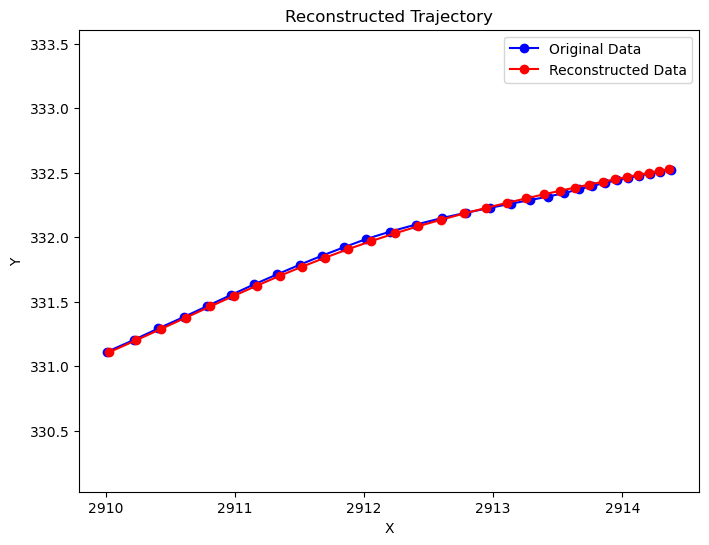

In [7]:
plt.figure(figsize=(8, 6))
# 绘制原始轨迹

# num = 845
num = np.random.randint(0,30000)
# num = 0
plt.plot(val_label.cpu().numpy()[num, :,0], val_label.cpu().numpy()[num, :,1], '-o',c='blue', label='Original Data')
plt.plot(val_output.cpu().numpy()[num, :,0], val_output.cpu().numpy()[num, :,1], '-o', c='red', label='Reconstructed Data')
plt.title('Reconstructed Trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.axis('equal')
plt.show()

In [8]:

# 定义专门用来重构轨迹的类, 计算误差ADE

class Reconstruct_Traj(Vehicle_Model_Methods):

    def __init__(self):
        super(Reconstruct_Traj, self).__init__()

    def ADE_err(self,out,label):
        ade = ((out - label) ** 2).sum(dim=2).sqrt().mean()
        return ade
    
    def AMDE_err(self,out,label):
        # 计算每个样本的误差
        error = ((out - label) ** 2).sum(dim=2).sqrt()
        # 提取最大值
        max_error, _ = error.max(dim=1)
        # 对最大值取平均
        amde = max_error.mean()
        return amde
    
    def calculate(self,actions,edagepoint,endstate,mode,labels):

        ax = actions[:,:,0]
        delta = actions[:,:,1]

        if mode == 'init_one':
            out = self.initial_unidirectional_reconstruct(ax,delta,edagepoint,endstate)
        elif mode == 'init_two':
            out = self.initial_bidirectional_reconstruct(ax,delta,edagepoint,endstate)
        elif mode == 'two_point':
            out,condtion = self.two_point_reconstruct(ax, delta, edagepoint, endstate)
        else:
            print(f'没有重构模式{mode}')
            out = torch.zeros(labels.shape, dtype=torch.float32, device=labels.device)
        
        loss_err1 = self.ADE_err(out,labels)
        loss_err1 = loss_err1.cpu().numpy()


        loss_err2 = self.AMDE_err(out,labels)
        loss_err2 = loss_err2.cpu().numpy()

        loss_err = [loss_err1,loss_err2]

        return loss_err

In [9]:
recon_tarj = Reconstruct_Traj()

err_init_one = recon_tarj.calculate(val_action,val_edagepoint,val_endstate,'init_one',val_label)
print('单点单向重构误差',err_init_one)

err_init_two = recon_tarj.calculate(val_action,val_edagepoint,val_endstate,'init_two',val_label)
print('单点双向重构误差',err_init_two)

# err_two_point = recon_tarj.calculate(val_action,val_edagepoint,val_endstate,'two_point',val_label)
# print('单点单向重构误差',err_two_point)

单点单向重构误差 [array(0.03500646, dtype=float32), array(0.08048785, dtype=float32)]
单点双向重构误差 [array(0.02757501, dtype=float32), array(0.05882214, dtype=float32)]
